<a href="https://colab.research.google.com/github/Arpitkamal/Deep-Learning---Deep-Convolutional-Neural-Networks/blob/master/HyperparameterTuning_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline


1.   Basic motivation of hyerparameter tuning
2.   Integrating Google colab with a local runtime (config in google colab, Browser, Jupyter notebook)
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrices with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them





In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [6]:
import mlflow
import mlflow.pytorch

# Params

In [7]:
class Params(object):
  def __init__(self, batch_size, epochs, seed, log_interval):
    self.batch_size = batch_size
    self.epochs = epochs
    self.seed = seed
    self.log_interval = log_interval

args = Params(256, 4, 0, 20)    

# Dataset

In [8]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True,
                           transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True,
                           transform= transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)


100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


113.5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


100.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


180.4%/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


# Model

In [27]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [28]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [36]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            image_path = 'pictures/%s.png' % (expt_id)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)
            

# Hyperparameter tuning loop


LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.882
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.558
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.385
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.317
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.390
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.301
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.370
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.394
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.375
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.365

Test set: Average loss: 0.0010, Accuracy: 9245/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.256
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.304
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.305
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.332
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.262
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.198
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.214
Train Epoch:

FileNotFoundError: ignored

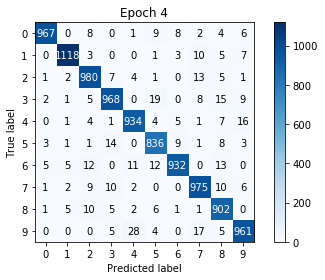

In [37]:
#expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "models")